# Optimizing Gas-Oil Ratio (GOR) Using Ant Colony Optimization (ACO)

## Objective
The goal of this project is to optimize the parameters of the **Glaso Correlation** model for estimating Gas-Oil Ratio (GOR) using **Ant Colony Optimization (ACO)**. The model involves several coefficients that need to be optimized to minimize the error between the estimated GOR values and the actual GOR values provided in the dataset.

### Step-by-Step Process:

1. **Glaso Correlation Function**:
   The `glaso_correlation` function calculates the estimated GOR based on a set of input parameters. It uses a formula that involves pressure (`Pb`), temperature (`Tb`), gas gravity (`gamma_g`), API gravity (`API`), and seven optimization coefficients (`alpha_1` to `alpha_7`). 

   - **Input Variables**:
     - `Pb`: Pressure (in psi)
     - `Tb`: Temperature (in Rankine)
     - `gamma_g`: Gas gravity (dimensionless)
     - `API`: API gravity of the oil (dimensionless)
     - `alpha_1` to `alpha_7`: Coefficients to be optimized

   - **Output**:
     - Estimated GOR (in scf/stb)

2. **Objective Function for Optimization**:
   The objective function computes the total error between the actual GOR values (`GOR_data`) and the predicted GOR values generated by the `glaso_correlation` function. The goal of optimization is to minimize this error.

   - **Input Variables**:
     - `Pb_data`: Array of pressure values (psi)
     - `Tb_data`: Array of temperature values (Rankine)
     - `GOR_data`: Actual observed GOR values (scf/stb)
     - `gamma_g`: Gas gravity
     - `API`: API gravity
     - `alpha_1` to `alpha_7`: Coefficients to optimize
   
   - **Output**:
     - Total error between predicted and actual GOR values

3. **Ant Colony Optimization (ACO) Algorithm**:
   The ACO algorithm is employed to optimize the coefficients (`alpha_1` to `alpha_7`). It simulates the behavior of ants searching for the best path, where the "path" corresponds to the set of optimal coefficients.

   - **Input Variables**:
     - `Pb_data`, `Tb_data`, `GOR_data`: Data for optimization
     - `gamma_g`, `API`: Constants used in the Glaso model
     - `n_ants`: Number of ants (search agents)
     - `n_iterations`: Number of iterations for the optimization process
     - `alpha`, `beta`, `rho`, `Q`: ACO parameters controlling pheromone influence, exploration, evaporation, and reward

   - **Output**:
     - The optimized coefficients (`alpha_1` to `alpha_7`)
     - The best error (measure of how well the optimized model fits the data)

4. **Optimization Results**:
   After running the ACO algorithm, the coefficients that minimize the error between predicted and actual GOR values are obtained. These coefficients are used to calculate the final **optimized GOR values** for the given data.

   - **Optimized Coefficients**:
     - `alpha_1` to `alpha_7`: The optimized coefficients found by ACO
   
   - **Optimized GOR**:
     - GOR values calculated using the `glaso_correlation` function with the optimized coefficients.

### Variables Overview:
- **Pb_data**: Array of pressure values (input to the model)
- **Tb_data**: Array of temperature values (input to the model)
- **GOR_data**: Array of actual GOR values (used for comparison)
- **gamma_g**: Gas gravity (constant)
- **API**: API gravity of the oil (constant)
- **alpha_1 to alpha_7**: Coefficients that are optimized using ACO

### Conclusion:
By optimizing the coefficients of the Glaso model using Ant Colony Optimization, the best-fit parameters for predicting GOR are determined. The final optimized GOR values can now be used for more accurate reservoir simulations and oil production forecasting.
and actual observed values.


In [20]:
import numpy as np

# Glaso correlation function with optimization parameters
def glaso_correlation(alpha_1, alpha_2, alpha_3, alpha_4, alpha_5, alpha_6, alpha_7, Pb, Tb, gamma_g, API):
    # Ensure pressure is positive to avoid log(0) or negative
    if Pb <= 0:
        raise ValueError("Pressure Pb must be positive")
    
    # Check temperature is above 460 to avoid division by zero
    if Tb <= 460:
        raise ValueError("Temperature Tb must be greater than 460")
    
    # Calculate x based on Pb and other parameters
    try:
        x = (alpha_4 - (alpha_5 - alpha_6 * np.log10(Pb))) ** alpha_7
    except Exception as e:
        print(f"Error calculating x: {e}")
        x = 0  # Default to 0 if error occurs
    
    # Cap the value of x to avoid extreme results
    x = np.clip(x, -10, 10)
    
    # Estimate Rs using the Glaso formula
    try:
        Rs_estimated = gamma_g * ((API ** alpha_1) / ((Tb - 460) ** alpha_2) * 10 ** x) ** alpha_3
    except Exception as e:
        print(f"Error calculating Rs: {e}")
        Rs_estimated = 0  # Default to 0 if error occurs
    
    return Rs_estimated

# Objective function for optimization
def objective_function(alpha_1, alpha_2, alpha_3, alpha_4, alpha_5, alpha_6, alpha_7, Pb_data, Tb_data, GOR_data, gamma_g, API):
    predicted_GOR = np.array([glaso_correlation(alpha_1, alpha_2, alpha_3, alpha_4, alpha_5, alpha_6, alpha_7, Pb, Tb, gamma_g, API)
                              for Pb, Tb in zip(Pb_data, Tb_data)])
    
    # Calculate Mean Absolute Error between actual and estimated GOR
    error = np.sum(np.abs(predicted_GOR - GOR_data)) / len(GOR_data)
    return error

# ACO optimization function to find the best parameters
def aco_optimize(Pb_data, Tb_data, GOR_data, gamma_g, API, n_ants=50, n_iterations=5000, alpha=1, beta=2, rho=0.01, Q=100):
    pheromones = np.ones((7, n_ants))  # Initialize pheromones for coefficients
    best_solution = [1.0] * 7  # Initial solution guess
    best_error = float('inf')
    
    # Main optimization loop
    for iteration in range(n_iterations):
        solutions = np.zeros((n_ants, 7))  # Store solutions for each ant
        errors = []

        # Each ant generates a solution and evaluates it
        for ant in range(n_ants):
            # Generate random coefficients based on pheromones, with adjusted bounds
            alpha_1 = np.random.uniform(0, 10) * pheromones[0, ant] ** alpha
            alpha_2 = np.random.uniform(0, 5) * pheromones[1, ant] ** beta
            alpha_3 = np.random.uniform(0, 2) * pheromones[2, ant] ** beta
            alpha_4 = np.random.uniform(0, 5) * pheromones[3, ant] ** beta
            alpha_5 = np.random.uniform(0, 5) * pheromones[4, ant] ** beta
            alpha_6 = np.random.uniform(0, 5) * pheromones[5, ant] ** beta
            alpha_7 = np.random.uniform(0, 2) * pheromones[6, ant] ** beta

            # Calculate error for the current solution
            error = objective_function(alpha_1, alpha_2, alpha_3, alpha_4, alpha_5, alpha_6, alpha_7, Pb_data, Tb_data, GOR_data, gamma_g, API)
            
            # Store the solution and error
            solutions[ant] = [alpha_1, alpha_2, alpha_3, alpha_4, alpha_5, alpha_6, alpha_7]
            errors.append(error)
            
            # Track the best solution so far
            if error < best_error:
                best_error = error
                best_solution = [alpha_1, alpha_2, alpha_3, alpha_4, alpha_5, alpha_6, alpha_7]

        # Update pheromones based on performance
        pheromones *= (1 - rho)  # Pheromone evaporation
        
        # Apply more rewarding pheromone update based on lower error
        for ant in range(n_ants):
            pheromone_update = Q / (errors[ant] + 1e-6)  # Prevent division by zero
            pheromones[:, ant] += pheromone_update

        # Print the best solution for each iteration
        print(f"Iteration {iteration + 1}, Best Error: {best_error}, Coefficients: {best_solution}")
    
    return best_solution, best_error

# Example PVT Data (Bubble Point Pressure, API Gravity, Gas Gravity, Reservoir Temperature, Actual GOR)
pvt_data = [
    {'bubble_point_pressure': 2405, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 737},
    {'bubble_point_pressure': 2200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 684},
    {'bubble_point_pressure': 1950, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 620},
    {'bubble_point_pressure': 1700, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 555},
    {'bubble_point_pressure': 1450, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 492},
    {'bubble_point_pressure': 1200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 429},
    {'bubble_point_pressure': 950, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 365},
    {'bubble_point_pressure': 700, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 301},
    {'bubble_point_pressure': 450, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 235},
    {'bubble_point_pressure': 200, 'api_gravity': 37, 'gas_gravity': 0.743, 'reservoir_temperature': 520, 'actual_gor': 155},
]

# Convert to arrays
Pb_data = np.array([entry['bubble_point_pressure'] for entry in pvt_data])  # Pressure values
Tb_data = np.array([entry['reservoir_temperature'] for entry in pvt_data])   # Temperature values
GOR_data = np.array([entry['actual_gor'] for entry in pvt_data])            # Actual GOR values

# Constants
gamma_g = 0.743   # Gas gravity value (same for all entries in this case)
API = 37.0        # API gravity value (same for all entries in this case)

# Running the ACO optimization
best_solution, best_error = aco_optimize(Pb_data, Tb_data, GOR_data, gamma_g, API)

# Displaying the optimized solution
print(f"Optimized coefficients: alpha_1 = {best_solution[0]}, alpha_2 = {best_solution[1]}, alpha_3 = {best_solution[2]}, "
      f"alpha_4 = {best_solution[3]}, alpha_5 = {best_solution[4]}, alpha_6 = {best_solution[5]}, alpha_7 = {best_solution[6]}")

C:\Users\CALEB\AppData\Local\Temp\ipykernel_27628\686060192.py:15: RuntimeWarning: invalid value encountered in scalar power
  x = (alpha_4 - (alpha_5 - alpha_6 * np.log10(Pb))) ** alpha_7
C:\Users\CALEB\AppData\Local\Temp\ipykernel_27628\686060192.py:25: RuntimeWarning: overflow encountered in scalar power
  Rs_estimated = gamma_g * ((API ** alpha_1) / ((Tb - 460) ** alpha_2) * 10 ** x) ** alpha_3


Iteration 1, Best Error: 344.6869452438371, Coefficients: [5.040382174113737, 2.3341731889207793, 0.22053348193492162, 3.451355717471837, 4.1222745178553675, 3.205538885207287, 1.6856438786197123]
Iteration 2, Best Error: 155.03977370106574, Coefficients: [6.184741466897261, 3.983289569948709, 0.5519743776834964, 3.0927866565781748, 1.8069031419043395, 0.6225354786430398, 0.6782645011063386]
Iteration 3, Best Error: 155.03977370106574, Coefficients: [6.184741466897261, 3.983289569948709, 0.5519743776834964, 3.0927866565781748, 1.8069031419043395, 0.6225354786430398, 0.6782645011063386]
Iteration 4, Best Error: 155.03977370106574, Coefficients: [6.184741466897261, 3.983289569948709, 0.5519743776834964, 3.0927866565781748, 1.8069031419043395, 0.6225354786430398, 0.6782645011063386]
Iteration 5, Best Error: 140.38173750494346, Coefficients: [10.271296553445888, 9.042130595344961, 0.5560343816987258, 9.162377610796398, 1.8635688762335416, 0.46634388544551447, 0.7325961298285047]
Iteration 

In [21]:
"""Taking the optimized coefficients a, b, c, d, e, f, g are found in best_solution
# Example: best_solution contains the optimized coefficients from the ACO optimization
# If best_solution is obtained from a previous ACO optimization process:
# best_solution = [best_a, best_b, best_c, best_d, best_e, best_f, best_g]"""

gamma_g = 0.743  # Example value for gas gravity
API = 37         # Example value for API gravity

# Extract each coefficient from best_solution (this should come from the ACO optimization)
best_a, best_b, best_c, best_d, best_e, best_f, best_g = best_solution

# Calculate the optimized GOR values using the complete set of coefficients
optimized_GOR = np.array([glaso_correlation(best_a, best_b, best_c, best_d, best_e, best_f, best_g, Pb, Tb, gamma_g, API)
                          for Pb, Tb in zip(Pb_data, Tb_data)])

print("Optimized GOR values:", optimized_GOR)

Optimized GOR values: [436.35611733 432.25527587 426.76073679 420.59130696 413.54394055
 405.30445109 395.34616602 382.67577783 365.0188604  334.58839939]


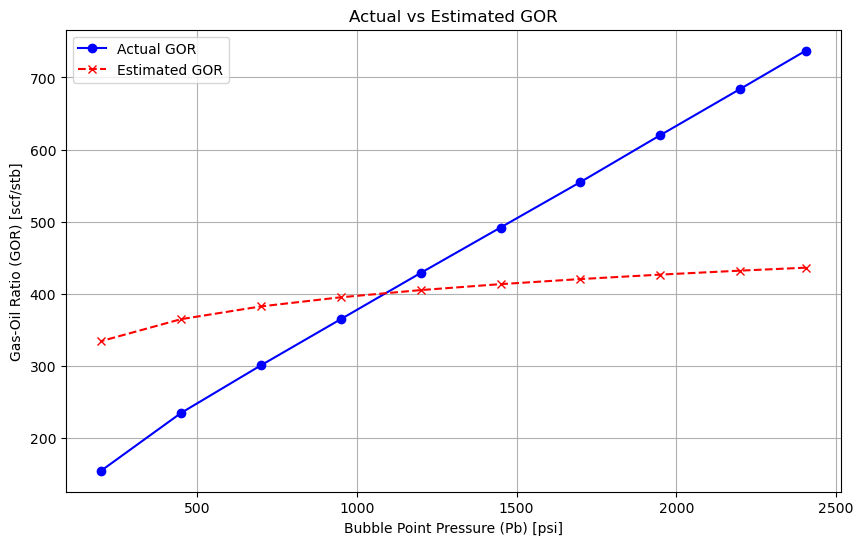

In [22]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(Pb_data, GOR_data, label='Actual GOR', color='b', marker='o', linestyle='-', markersize=6)
plt.plot(Pb_data, optimized_GOR, label='Estimated GOR', color='r', marker='x', linestyle='--', markersize=6)

# Add labels and title
plt.xlabel('Bubble Point Pressure (Pb) [psi]')
plt.ylabel('Gas-Oil Ratio (GOR) [scf/stb]')
plt.title('Actual vs Estimated GOR')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()